# 🧠 MRI Data Attack & Evaluation
This notebook simulates adversarial perturbations on brain MRI axial slices to evaluate model robustness. We implement two types of synthetic attacks:

In [1]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

# 1. Attack

## 1.1. Tumor Injection

In [1]:
import os
import cv2
import numpy as np
import random
from glob import glob

# Setup input and output directories
input_dir = "/kaggle/input/axial-mri-norm"
output_dir = "/kaggle/working/attacked_images"
os.makedirs(output_dir, exist_ok=True)

# Choose a subset of images to attack
attack_ratio = 0.3
image_paths = sorted(glob(os.path.join(input_dir, "*.png")))
num_attack = int(len(image_paths) * attack_ratio)
attack_indices = set(random.sample(range(len(image_paths)), num_attack))
attacked_ids = []


# Function to add a synthetic lesion near cortical areas
def add_fake_lesion(image):
    h, w = image.shape
    side = random.choice(['left', 'right'])
    if side == 'left':
        x = random.randint(w // 8, w // 2 - 10)
    else:
        x = random.randint(w // 2 + 10, 7 * w // 8)
    y = random.randint(h // 4, 3 * h // 4)

    center = (x, y)
    radius = random.randint(5, 12)
    intensity = random.uniform(0.5, 0.7)

    lesion_mask = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(lesion_mask, center, radius, 255, -1)
    blur_size = random.choice([7, 9, 11])
    lesion_mask = cv2.GaussianBlur(lesion_mask, (blur_size, blur_size), 0)

    attacked = cv2.addWeighted(image, 1, lesion_mask, intensity, 0)
    return attacked

# Loop through all images and apply attacks
for idx, img_path in enumerate(image_paths):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = (img * 0.85).astype(np.uint8)  # darken the whole image slightly

    if idx in attack_indices:
        img = add_fake_lesion(img)
        basename = os.path.basename(img_path)
        id_num = basename.split("sub-BrainAge")[1].split("_")[0]
        attacked_ids.append(id_num)

    out_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(out_path, img)

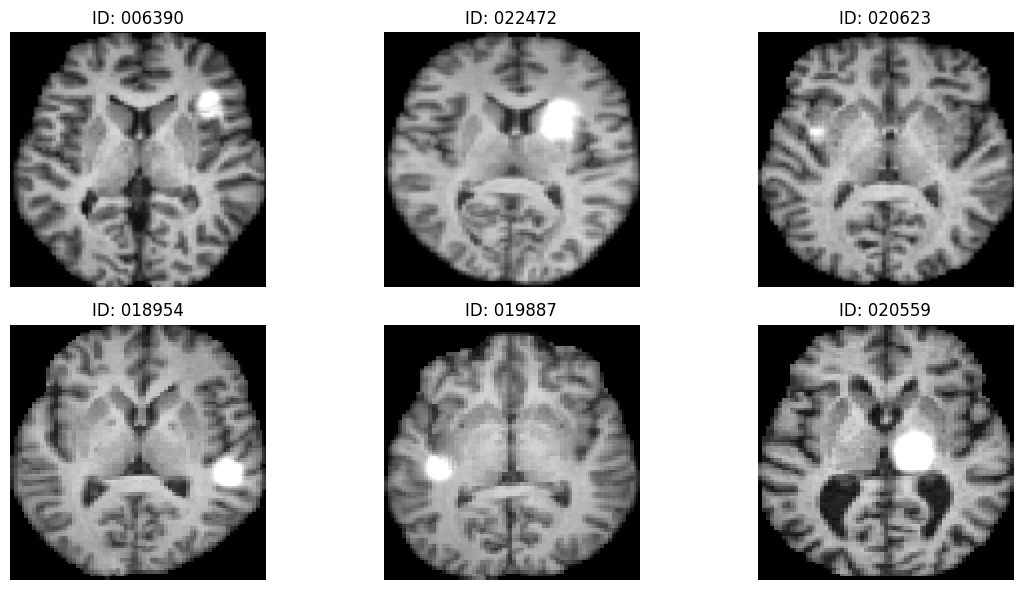

In [2]:
import matplotlib.pyplot as plt

sample_ids = random.sample(attacked_ids, min(6, len(attacked_ids)))

plt.figure(figsize=(12, 6))
for i, id_num in enumerate(sample_ids):
    filename = f"sub-BrainAge{id_num}_T1w_axial_center.png"
    img_path = os.path.join(output_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"ID: {id_num}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import shutil

folder_path = "/kaggle/working/attacked_images"
zip_path = "/kaggle/working/attacked_images.zip"

shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

'/kaggle/working/attacked_images.zip'

## 1.2. Gaussian attack

In [4]:
import os
import cv2
import numpy as np
import random
from glob import glob

# --- Cài đặt ---
input_dir = "/kaggle/input/axial-mri-norm"
output_dir = "/kaggle/working/gaussian_noise_attack"
os.makedirs(output_dir, exist_ok=True)

attack_ratio = 0.2
noise_std_range = (5, 30)

image_paths = sorted(glob(os.path.join(input_dir, "*.png")))
num_attack = int(len(image_paths) * attack_ratio)
attack_indices = set(random.sample(range(len(image_paths)), num_attack))

# --- Hàm thêm Gaussian noise ---
def add_gaussian_noise(image):
    image = cv2.resize(image, (128, 128))
    std = random.uniform(*noise_std_range)
    noise = np.random.normal(0, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

# --- Xử lý ảnh ---
for idx, img_path in enumerate(image_paths):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    if idx in attack_indices:
        img = add_gaussian_noise(img)

    out_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(out_path, img)

print(f"✅ Added Gaussian noise to {num_attack} / {len(image_paths)} images.")

✅ Added Gaussian noise to 772 / 3863 images.


In [5]:
import shutil

folder_path = "/kaggle/working/gaussian_noise_attack"
zip_path = "/kaggle/working/gaussian_noise_attack.zip"

shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

'/kaggle/working/gaussian_noise_attack.zip'

# 2. Evaluate

## 2.1. CONFIG

In [3]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from tqdm import tqdm
import glob

In [44]:
real_img_dir = '/kaggle/input/2d-mri-nocontrol/z'
generator_path = '/kaggle/input/cleanlsgan/pytorch/default/1/cleanLSGAN.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 128
img_size = 128

num_samples = 200
batch_size = 128

## 2.2. DATASET CLASS

In [43]:
class MRISliceDataset(Dataset):
    def __init__(self, image_dir, transform=None, num_samples=None):
        self.image_dir = image_dir
        self.transform = transform
        
        image_paths = [os.path.join(image_dir, fname) 
                       for fname in os.listdir(image_dir) 
                       if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if num_samples is not None:
            self.image_paths = image_paths[:num_samples]
        else:
            self.image_paths = image_paths
        
        print(f"Loaded {len(self.image_paths)} 2D MRI slice images from: {image_dir}")
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L") 
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [45]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(1),  # Ensure single channel
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

In [46]:
real_dataset = MRISliceDataset(real_img_dir, transform, num_samples)
real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)

Loaded 200 2D MRI slice images from: /kaggle/input/2d-mri-nocontrol/z


## 2.3. LOAD GENERATOR

In [38]:
# class Generator(nn.Module):
#     def __init__(self, latent_dim, img_size, channels=1):
#         super(Generator, self).__init__()

#         self.init_size = img_size // 4
#         self.latent_dim = latent_dim
        
#         self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

#         self.conv_blocks = nn.Sequential(
#             nn.BatchNorm2d(128),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, channels, 3, stride=1, padding=1),
#             nn.Tanh(),
#         )

#     def forward(self, z):
#         out = self.l1(z)
#         out = out.view(out.shape[0], 128, self.init_size, self.init_size)
#         img = self.conv_blocks(out)
#         return img
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [39]:
generator = Generator().to(device)
generator.load_state_dict(torch.load(generator_path, map_location=device))
generator.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=128, out_features=131072, bias=True)
  )
  (conv_blocks): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)

## 2.4. GENERATE FAKE IMAGES

100%|██████████| 4/4 [00:13<00:00,  3.48s/it]

Generated images shape: torch.Size([200, 1, 128, 128])


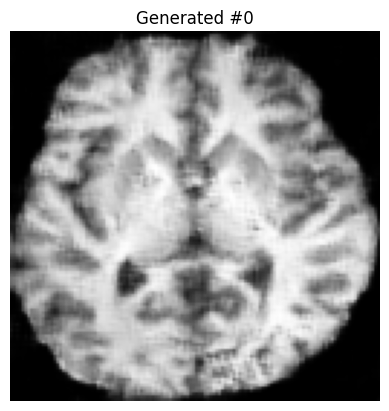

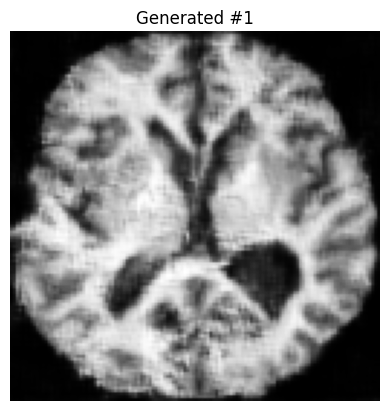

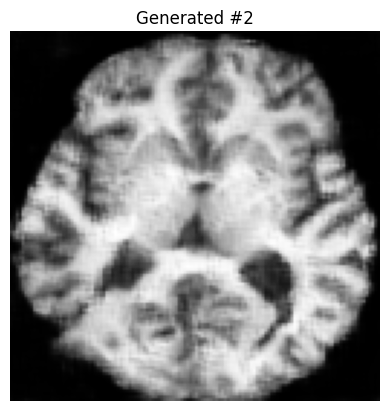

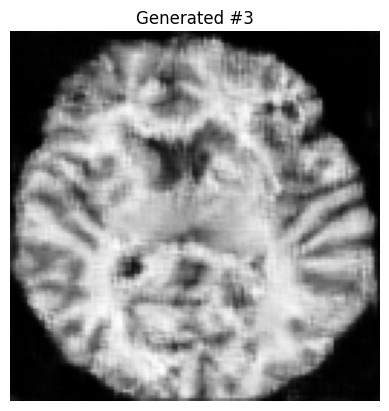

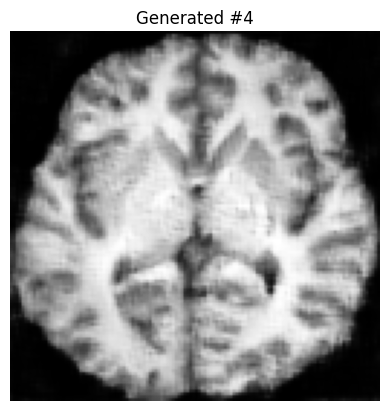

In [47]:
def generate_fake_images(generator_path, num_samples=num_samples, batch_size=64):
    from tqdm import tqdm

    generator = Generator().to(device)
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    generator.eval()

    generated = []
    with torch.no_grad():
        for _ in tqdm(range(0, num_samples, batch_size)):
            current_batch_size = min(batch_size, num_samples - len(generated) * batch_size)
            z = torch.randn(current_batch_size, latent_dim, device=device)
            imgs = generator(z)
            imgs = (imgs + 1) / 2  # scale to [0, 1]
            generated.append(imgs.cpu())

    all_images = torch.cat(generated, dim=0)

    print("Generated images shape:", all_images.shape)
    for i in range(5):
        img = all_images[i][0].numpy()
        plt.imshow(img, cmap='gray')
        plt.title(f"Generated #{i}")
        plt.axis('off')
        plt.show()

    return all_images

fake_images = generate_fake_images(
    generator_path="/kaggle/input/cleanlsgan/pytorch/default/1/cleanLSGAN.pt",
    num_samples=num_samples,
    batch_size=64
)

## 2.5. EXTRACT FEATURES

In [48]:
inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
inception.eval()
inception.fc = torch.nn.Identity()  # remove final classification layer
transform_resize = transforms.Resize((299, 299))

def extract_features(images_tensor):
    feats = []
    with torch.no_grad():
        for i in tqdm(range(0, len(images_tensor), batch_size)):
            batch = images_tensor[i:i+batch_size]
            batch = batch.repeat(1, 3, 1, 1)  # convert 1-channel to 3-channel
            batch = torch.stack([transform_resize(img) for img in batch])
            batch = batch.to(device)
            feat = inception(batch)
            feats.append(feat.cpu().numpy())
    return np.concatenate(feats, axis=0)

# Real images to tensor
real_images = []
for imgs in real_loader:
    imgs = (imgs + 1) / 2
    real_images.append(imgs)
real_images = torch.cat(real_images, dim=0)

# Extract features
features_real = extract_features(real_images)
features_fake = extract_features(fake_images)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 179MB/s] 
100%|██████████| 2/2 [00:41<00:00, 20.80s/it]


## 2.6. CALCULATE FID

In [49]:
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)

mu_real = np.mean(features_real, axis=0)
sigma_real = np.cov(features_real, rowvar=False)
mu_fake = np.mean(features_fake, axis=0)
sigma_fake = np.cov(features_fake, rowvar=False)

fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"\n🎯 FID Score = {fid_score:.2f}")


🎯 FID Score = 137.11


## 2.8. Calculate LPIPS

In [50]:
import lpips
import torch.nn.functional as F

# LPIPS model (use AlexNet as backbone)
lpips_model = lpips.LPIPS(net='alex').to(device)
lpips_model.eval()

# Ensure real and fake images are aligned
real_images = []
for batch in real_loader:
    real_images.append(batch)
real_images = torch.cat(real_images, dim=0)
real_images = real_images[:fake_images.shape[0]].to(device)

# Expand to 3 channels for LPIPS (expected input shape: [N, 3, H, W])
def expand_to_3_channels(imgs):
    return imgs.repeat(1, 3, 1, 1)

real_lpips = expand_to_3_channels(real_images)
fake_lpips = expand_to_3_channels(fake_images.to(device))

# Compute LPIPS
with torch.no_grad():
    lpips_scores = lpips_model(fake_lpips, real_lpips)
    mean_lpips = lpips_scores.mean().item()

print(f"Mean LPIPS score: {mean_lpips:.4f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 125MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Mean LPIPS score: 0.4413
